## Drawing point-line configurations.

In this notebook we give basic tools for drawing point-line configurations
and other geometric incidence structures.

We represent a point-line incidence structure as a dictionary of points
p: (x,y)
and a dictionary of hyperline segments:
L : (p,q)
It is important that the line segments span the points at gratest distance.

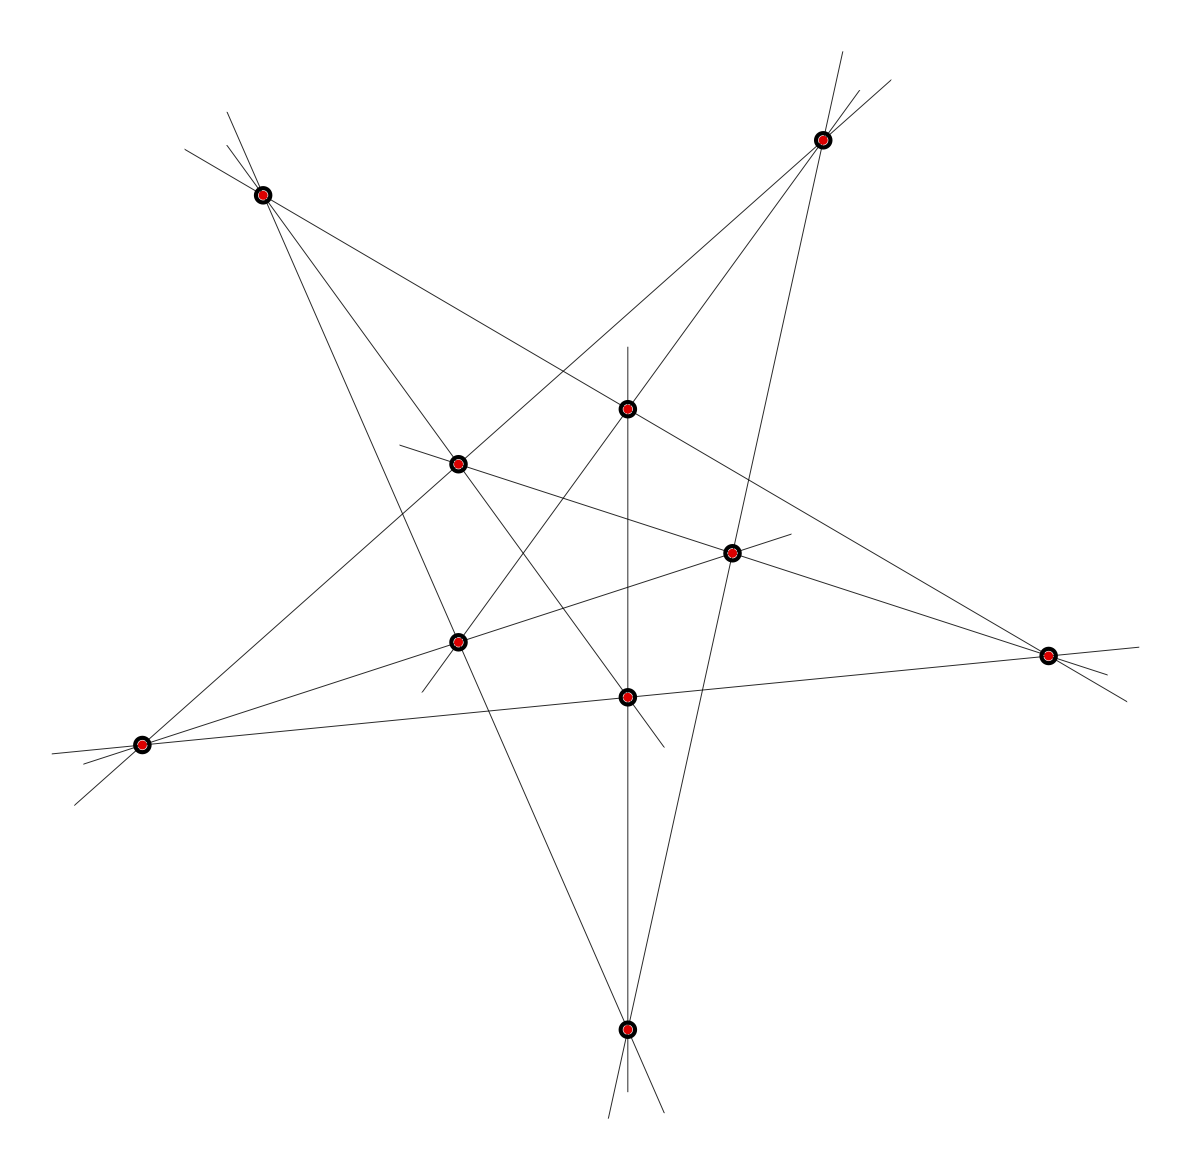


In this notebook we will construct sporadic examples.

### Version of August 17, 2022
### by Tomaž Pisanski

#### TO DO:
* tikz output does not use colors properly. 
* add an option to draw elements of configuration with different colors. 
* improve the use of folders for storing output files.
* disks representing points are not always of the same size. 

In [ ]:
from functools import reduce
import numpy as np
from itertools import permutations
from sympy import primefactors
#os.mkdir("experiments")
#
# Currently, all drawings are stored in a hardwired folder "experiments".
#
# You may uncomment the following line and then store the drawings in a different directory,
#e.g. "figures"
#
folder = "figures"
#os.mkdir(folder)

###########################
#
###########################
tex_header = r'''\documentclass[border=2mm]{standalone}
\usepackage{tikz}
\begin{document}
\begin{tikzpicture}[fill=blue,line width=1pt,fill opacity=0.9,scale=0.05]
\tikzstyle{every path}=[draw, thick]
\tikzstyle{every node}=[draw, circle, fill=red, inner sep=1.0pt]
'''

tex_footer =  r'''\end{tikzpicture}
\end{document}'''


def draw_cfg_latex(vts,lns,fig_name,folder = ''):
    f = open(folder + fig_name + '.tex', 'w')
    ret = tex_header
    for v, coord in vts.items():
        coord = float(coord[0]), float(coord[1])
        ret += r'\coordinate (v_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(v, coord[0], coord[1]) + '\n'
    for ll, (coord1,coord2) in lns.items():
        crd1 = float(coord1[0]), float(coord1[1])
        crd2 = float(coord2[0]), float(coord2[1])
        ret += r'\coordinate (u_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(ll, crd1[0], crd1[1]) + '\n'
        ret += r'\coordinate (w_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(ll, crd2[0], crd2[1]) + '\n'
    enu = {}
    for li in lns:
        u,v = lns[li]
        ret += r'\path (u_{0}) -- (w_{1});'.format(li, li) + '\n'
    for v, coord in vts.items():
        coord = float(coord[0]), float(coord[1])
        ret += r'\node (v_{0}) at ({1:.5f}, {2:.5f}) {{}};'.format(v, coord[0], coord[1]) + '\n'
    ret += tex_footer
    f.write(ret)
    f.close()
    
def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def circle_line_segment_intersection(circle_center, circle_radius, pt1, pt2, full_line=True, tangent_tol=1e-9):
    """ Find the points at which a circle intersects a line-segment.  This can happen at 0, 1, or 2 points.

    :param circle_center: The (x, y) location of the circle center
    :param circle_radius: The radius of the circle
    :param pt1: The (x, y) location of the first point of the segment
    :param pt2: The (x, y) location of the second point of the segment
    :param full_line: True to find intersections along full line - not just in the segment.  False will just return intersections within the segment.
    :param tangent_tol: Numerical tolerance at which we decide the intersections are close enough to consider it a tangent
    :return Sequence[Tuple[float, float]]: A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.

    Note: We follow: http://mathworld.wolfram.com/Circle-LineIntersection.html
    (from StackOverflow)
    """

    (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
    (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
    dx, dy = (x2 - x1), (y2 - y1)
    dr = (dx ** 2 + dy ** 2)**.5
    big_d = x1 * y2 - x2 * y1
    discriminant = circle_radius ** 2 * dr ** 2 - big_d ** 2

    if discriminant < 0:  # No intersection between circle and line
        return []
    else:  # There may be 0, 1, or 2 intersections with the segment
        intersections = [
            (cx + (big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr ** 2,
             cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr ** 2)
            for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
        if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
            fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
            intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
        if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
            return [intersections[0]]
        else:
            return intersections

def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def dist(pta,ptb):
    """Euclidean distance between two point in the plane."""
    xa = pta[0]
    ya = pta[1]
    xb = ptb[0]
    yb = ptb[1]
    res = sqrt(float((xa-xb)*(xa-xb) + (ya-yb)*(ya-yb)))
    return res

def envelopping_circle(vts,lns,eps=0.1):
    cx = 0
    cy = 0
    for p in vts:
        (vx,vy) = vts[p]
        cx += float(vx)
        cy += float(vy)
    n = len(vts)
    cx = cx/float(n)
    cy = cy/float(n)
    cen = (cx,cy)
    rmax = 0
    for p in vts:
        rr = dist(cen,vts[p])
        if rr > rmax:
            rmax = rr
    radius = rmax*(1+eps)
    return cen,radius


def prepare_for_drawing(vts,lns,eps=0.2,dt="N"):
    """Prepare for drawing lines, depending on the type dt. 
    lns are given as pair of abstract points. nlns are computed as pair of coordinates.
    dt ... 'N' use points coordinates
       ... 'L' extend each line segment by eps.
       ... 'C' extend each line to its intersection with the encompassing circle. """
    nlns = {}
    if dt == "C": #extend to circle
        cx = 0
        cy = 0
        for p in vts:
            (vx,vy) = vts[p]
            cx += float(vx)
            cy += float(vy)
        n = len(vts)
        cx = cx/float(n)
        cy = cy/float(n)
        cen = (cx,cy)
        rmax = 0
        for p in vts:
            rr = dist(cen,vts[p])
            if rr > rmax:
                rmax = rr
        radius = rmax*(1+eps) # circle (cen, radius)  contains all configuration points.
        for k in lns:
            (p,q) = lns[k]
            (xp,yp) = vts[p]
            (xq,yq) = vts[q]
            res = circle_line_segment_intersection(cen, radius, vts[p], vts[q], full_line=True, tangent_tol=1e-9)
            ((xxp,yyp),(xxq,yyq)) = res
            nlns[k] = res
    elif dt == "L":
        for k in lns:
            (p,q) = lns[k]
            (xp,yp) = vts[p]
            (xq,yq) = vts[q]
            xxp = xp + eps*(xp-xq)
            xxq = xq + eps*(xq-xp)
            yyp = yp + eps*(yp-yq)
            yyq = yq + eps*(yq-yp)
            res = ((xxp,yyp),(xxq,yyq))
            nlns[k] = res
    else:    #dt = "N"
        for k in lns:
            (p,q) = lns[k]
            (xp,yp) = vts[p]
            (xq,yq) = vts[q]
            res = ((xp,yp),(xq,yq))
            nlns[k] = res
    return vts,nlns

def scale_points(vts,R = 100):
    """Scale point coordinates. Useful for ensuring approximately the same size
    points."""
    Rmax = 0
    for v in vts:
        (x,y) = vts[v]
        if abs(x) > Rmax:
            Rmax = abs(x)
        if abs(y) > Rmax:
            Rmax = abs(y)
    nvts = {}
    for v in vts:
        (x,y) = vts[v]
        nx = x*R/Rmax
        ny = y*R/Rmax
        nvts[v] = (nx,ny)
    return nvts

def reduce_points(vts,lns):
    """On each line keep only extreme points"""
    nlns = {}
    for ll in lns:
        pts = lns[ll]
        dmax = 0
        pmax = 0
        qmax = 0
        for p in pts:
            (xp,yp) = vts[p]
            for q in pts:
                if q <= p:
                    continue
                (xq,yq) = vts[q]
                d = sqrt((xp-xq)**2 + (yp-yq)**2)
                if d > dmax:
                    dmax = d
                    pmax = p
                    qmax = q
        nlns[ll] = (pmax,qmax)
    return (vts,nlns)

def plot_configuration(uts,lns,eps = 0.2,dt="N",where="S",fname = None,r=3,cline="black",cpoint="red",th=0.2):
    """plot configuration vts,lns, depending on type:
    dt ... 'N' use points coordinates
       ... 'L' extend each line segment by eps.
       ... 'C' extend each line to its intersection with the encompassing circle. 
    where ... 'S' - screen  (ignor fname)
          ... 'P' - as pdf on file fname.pdf
          ... 'T  - as tizk on file fname.tex '"""
    vts = scale_points(uts)
    pts,rlns = reduce_points(vts,lns)
    pts,nlns = prepare_for_drawing(pts,rlns,eps,dt)
    if where == "T": # draw using tikz on a .tex file
        draw_cfg_latex(pts,nlns,fname)
        return
    plt = Graphics()
    for k in nlns:
        ((xp,yp),(xq,yq)) = nlns[k]
        plt += line(((xp,yp),(xq,yq)),color = cline,thickness=th)
    for m in pts:
        (x,y) = pts[m]
        plt += circle((x,y),r,color = cline)
        plt += circle((x,y),r-1,color = cpoint,fill=True)
    if where == "S":
        plt.show(axes=False)
        plt.axes(False)
        return plt
    elif where == "P": #save pdf
        plt.save(fname+".pdf",axes=False)
        
    


### Examples of Configurations for testing purposes

In [ ]:
def L21_4(n = 7,R = 100):
    """Grunbaum-Rigby configuration (for n = 7)"""
    vts = {}
    for i in range(n):
        x = float(R*sin(2*pi*i/n))
        y = float(R*cos(2*pi*i/n))
        vts[i] = (x,y)
    for i in range(n):
        j = (i + 2)%n
        ii = (i-1)%n
        jj = (j-1)%n
        (xx,yy) = line_intersection((vts[i],vts[j]),(vts[ii],vts[jj]))
        vts[i+n] = (xx,yy)
    for i in range(n):
        iii = i + n
        jjj = (i+3)%n + n
        iiii = (i-2)%n + n
        jjjj = (i+1)%n + n
        (xxx,yyy) = line_intersection((vts[iii],vts[jjj]),(vts[iiii],vts[jjjj]))
        vts[i+2*n] = (xxx,yyy)
    lns = {}
    for i in range(n):
        lns[i] = (i,(i+2)%n)
        lns[i+n] = (i,(i+3)%n)
        lns[i+2*n] = (i+n, (i+3)%n + n)
    return (vts,lns)

def pappus(n=3,R=100,r=50,phi=10):
   """Pappus configuration. for n = 3. 
   For n > 3, incidences are missing."""
   vts = {}
   for i in range(n):
        x = float(R*sin(2*pi*i/n))
        y = float(R*cos(2*pi*i/n))
        vts[i] = (x,y)
        x = float(r*sin(phi+2*pi*i/n))
        y = float(r*cos(phi+2*pi*i/n))
        vts[n+i] = (x,y)
   for i in range(n):
      j = n+(i+1)%n
      ii = (i-1)%n
      jj = n + (i-1)%n
      (xx,yy) = line_intersection((vts[i],vts[j]),(vts[ii],vts[jj]))
      vts[i+2*n] = (xx,yy)
   lns = {}
   for i in range(n):
        lns[i] = (i,2*n+(i-1)%n)
        lns[n+i] = (i,n+i)
        lns[2*n+i] = (i,n+(i+1)%n)
        lns[3*n+i] = (i,2*n+(i-0)%n)
        lns[4*n+i] = (i,n+(i-1)%n)
        lns[5*n+i] = (i,2*n+(i+1)%n)
   return(vts,lns)

def near_pencil(n):
    R = 50
    pts = {0:(0,5*R)}
    a = float((n-1)/2)
    for i in range(n):
        pts[i+1] = ((i-a)*R,0)
    lns = {0:(1,n)}
    for i in range(n):
        lns[i+1] = (0,i+1)
    return pts,lns

def standard_pappus():
    R = 50
    a = vector((R,R))
    b = vector((-R,R))
    c = vector((-R,-R))
    d = vector((R,-R))
    e = (a+b)/2
    f = (c+d)/2
    g = line_intersection((a,c),(b,d))
    h = line_intersection((a,f),(e,d))
    i = line_intersection((b,f),(e,c))
    pp = (a,b,c,d,e,f,g,h,i)
    pts = {i:pp[i] for i in range(9)}
    ll = [(0,1),(2,3),(7,8),(2,4),(2,0),(1,5),(1,3),(0,5),(3,4)]
    lns = {i:ll[i] for i in range(9)}
    return(pts,lns)


### Test runs
A subfolder experiments should exist (not needed in the first run that  displays Grünbaum-Rigby configuration.) 

In [ ]:
(pts,lns) = L21_4()
plot_configuration(pts,lns,fname="experiments/pappusNS",dt="N",where="S",r=4,th = 3,cline="red",cpoint="gold")
plot_configuration(pts,lns,fname="experiments/pappusLS",dt="L",where="S",th=0.1)
plot_configuration(pts,lns,fname="experiments/pappusCS",dt="C",where="S")


In [ ]:
(pts,lns) = near_pencil(8)
plot_configuration(pts,lns,fname="experiments/testNT",dt="N",where="T")
plot_configuration(pts,lns,fname="experiments/testLT",dt="L",where="T")
plot_configuration(pts,lns,fname="experiments/testCT",dt="C",where="T")
plot_configuration(pts,lns,fname="experiments/testNP",dt="N",where="P")
plot_configuration(pts,lns,fname="experiments/testLP",dt="L",where="P")
plot_configuration(pts,lns,fname="experiments/testCP",dt="C",where="P")
plot_configuration(pts,lns,fname="experiments/testNS",dt="N",where="S")
plot_configuration(pts,lns,fname="experiments/testLS",dt="L",where="S")
plot_configuration(pts,lns,fname="experiments/testCS",dt="C",where="S")


In [ ]:
(pts,lns) = standard_pappus()
plot_configuration(pts,lns,dt="L",where="S",th=0.5)


In [ ]:
(pts,lns) = pappus()
plt = plot_configuration(pts,lns,dt="C",where="S",th=0.5)
center,radius = envelopping_circle(pts,lns,eps=0)
plt += circle(center,radius)
plt.show(axes=False)
center,radius = envelopping_circle(pts,lns,eps=0.2)
plt += circle(center,radius)
plt.show(axes=False)
